Extracted features shape: (2661, 6)
Test data shape: (979, 128, 128)
Test labels shape: (979,)


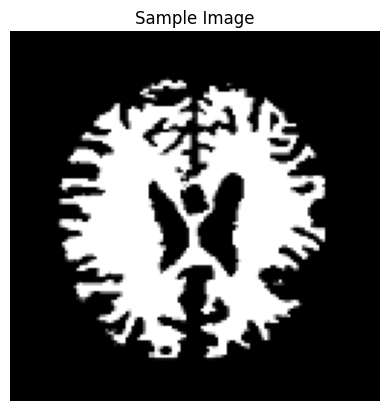

Actual Label: VeryMildDemented
Predicted Label: ['VeryMildDemented']
Accuracy: 0.4943820224719101
Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.57      0.26      0.36       179
ModerateDemented       1.00      0.17      0.29        12
     NonDemented       0.00      0.00      0.00       340
VeryMildDemented       0.49      0.97      0.65       448

        accuracy                           0.49       979
       macro avg       0.52      0.35      0.32       979
    weighted avg       0.34      0.49      0.37       979



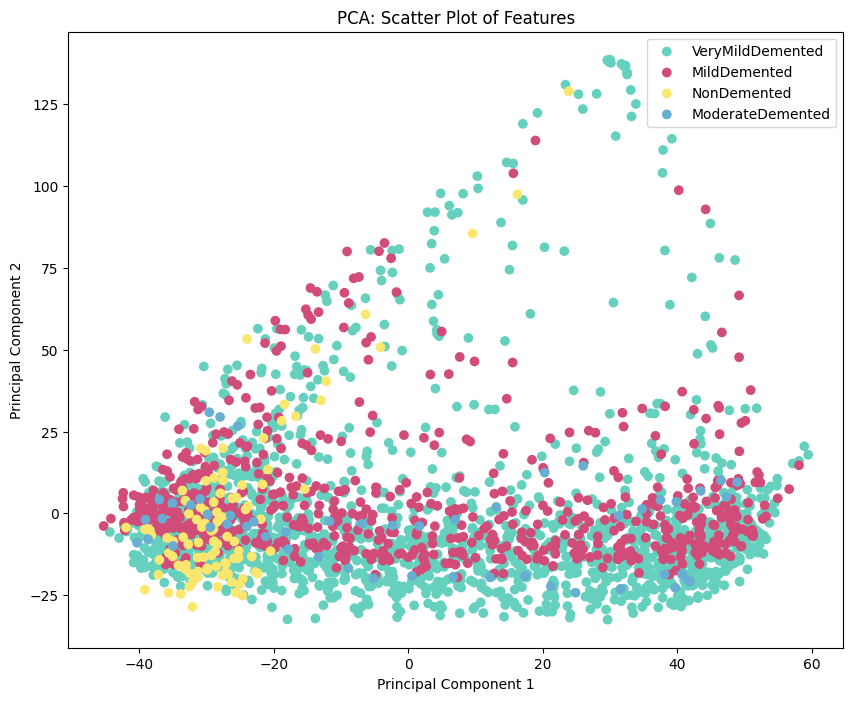

In [ ]:
#Alzheimer's prediction using MRI scans
#21pt28, 21pt32

import zipfile
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to compute texture features (GLCM properties) and statistical features
def compute_features(image):
    # Convert image to grayscale
    gray_image = rgb2gray(image)

    # Compute GLCM
    gray_image_uint = (gray_image * 255).astype(np.uint8)
    glcm = graycomatrix(gray_image_uint, [5], [0], symmetric=True, normed=True)


    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # Statistical features
    mean_intensity = np.mean(gray_image)
    std_intensity = np.std(gray_image)

    return [contrast, correlation, energy, homogeneity, mean_intensity, std_intensity]

# Path for the zip file and extraction directory
zip_file_path = "/content/Alzheimer_s Dataset-20231029T152207Z-001.zip"

extraction_dir = "/content/Alzheimer_s Dataset/Alzheimer_s Dataset/Alzheimer_s Dataset/"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

# Check the extracted files
extracted_files = os.listdir(extraction_dir)
train_data = []
train_labels = []

# Path to the train folder
train_folder = os.path.join(extraction_dir, "train")

# Create a directory to save the images and visualizations
output_dir = "/content/visualise"
os.makedirs(output_dir, exist_ok=True)

# Function to preprocess an image
def preprocess_image(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding
    _, binary_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)  # Adjust threshold value as needed

    # Resize the image
    image = cv2.resize(binary_image, (128, 128))  # Adjust the size as needed

    # Normalize pixel values to [0, 1]
    image = image.astype('float32') / 255.0

    return image

# Extract features for each image in the dataset
features = []
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            # Load the image using OpenCV (or any other image loading library)
            image = cv2.imread(image_path)

            # Preprocess the image
            preprocessed_image = preprocess_image(image)

            # Compute image features
            image_features = compute_features(image)

            # Save the images
            image_filename = f"{label}_{image_file}"
            cv2.imwrite(os.path.join(output_dir, image_filename), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            cv2.imwrite(os.path.join(output_dir, f"{image_filename}_grey.jpg"), preprocessed_image * 255.0)
            cv2.imwrite(os.path.join(output_dir, f"{image_filename}_bin.jpg"), preprocessed_image * 255.0)

            # Append computed features

            features.append(image_features)
            train_data.append(preprocessed_image)
            train_labels.append(label)

# Convert the features list to a NumPy array
features = np.array(features)
#print(features)
# Display the shape of the extracted features
print("Extracted features shape:", features.shape)


data_with_labels = np.column_stack((features, train_labels))
#print(data_with_labels)
# Extract features (X) and target labels (y)
X = data_with_labels[:, :-1]  # Features (all columns except the last one)
y = data_with_labels[:, -1]   # Target labels (the last column)

# Assume you have test data in a folder named "test"
test_folder = os.path.join(extraction_dir, "test")

# Process test data to extract features and create the test feature matrix and target vector
test_data = []
test_labels = []
test_features=[]
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    if os.path.isdir(label_path):
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            # Load the image using OpenCV (or any other image loading library)
            image = cv2.imread(image_path)
            # Preprocess the image
            preprocessed_image = preprocess_image(image)
            # Compute image features
            image_features = compute_features(image)
            # Append the features and label
            test_features.append(image_features)
            test_data.append(preprocessed_image)
            test_labels.append(label)

# Convert the test data to NumPy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Print the shapes of test data and labels
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)


train_data = np.array(train_data)
test_data = np.array(test_data)

# Convert train_labels and test_labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Split the data into training and testing sets

X_train, X_test = train_data, test_data
y_train, y_test = train_labels, test_labels

#X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
#X_test_flattened = X_test.reshape(X_test.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Scale the flattened features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)


# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)  # Linear kernel, you can experiment with other kernels

# Train the SVM model
svm_model.fit(X_train_scaled, y_train_encoded)

# Predict on the test set
y_pred = svm_model.predict(X_test_scaled)

# Decode the predicted labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Select a specific test data sample (for example, the first one)
sample_index = 5

sample_image = test_data[sample_index]
plt.imshow(sample_image, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()

# Get the actual label for the selected sample
actual_label = y_test[sample_index]

# Get the features of the selected test sample
selected_test_sample = X_test_scaled[sample_index].reshape(1, -1)

# Predict the label for the selected sample
predicted_label_encoded = svm_model.predict(selected_test_sample)

# Decode the predicted label
predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

# Print the actual label and the predicted label for the selected sample
print("Actual Label:", actual_label)
print("Predicted Label:", predicted_label)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_decoded)
print("Accuracy:", accuracy)

# Generate a classification report
report = classification_report(y_test, y_pred_decoded)
print("Classification Report:\n", report)


# Perform PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for visualization
import pandas as pd
df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
df['Label'] = y_train
class_colors = ['#65d0be', '#d14c78', '#fbe66e', '#68add2']
label_to_color = dict(zip(df['Label'].unique(), class_colors))

# Map labels to colors
df['Color'] = df['Label'].map(label_to_color)

# Scatter plot
plt.figure(figsize=(10, 8))
for label in df['Label'].unique():
    label_data = df[df['Label'] == label]
    plt.scatter(label_data['PC1'], label_data['PC2'], color=label_data['Color'], label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Scatter Plot of Features')
plt.legend()
plt.show()
